# Comparison of Linear Regression and KNN Regression Algorithms

In this notebook I'm going to compare two regression models' prediction abilities. Chance of Admit will be our outcome variable. 
suggested formula for OLS model is:
$$ Chance of Admit = \alpha + CGPA + GRE + TOEFL + Research + LOR + SOP$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn import neighbors

from scipy.stats import norm
import statsmodels.formula.api as smf

## EDA & Data Preparation

In [26]:
# load the dataset
df = pd.read_csv(r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 1\Datas\GraduationAdmission\Admission_Predict.csv')

# first 5 rows
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [28]:
# presence of missing values
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [29]:
# remove the Serial No columns as it does not benefit.
df.drop(['Serial No.'], axis = 1, inplace = True)

# remove the whistespace in the ending of the column and simplify the column names
df.rename(columns = {'Chance of Admit ':'Chance_of_Admit', 'TOEFL Score':'TOEFL', 'GRE Score':'GRE',
                    'University Rating': 'UR', 'LOR ':'LOR'}, inplace = True)

The dataset has 8 variables and 400 entries. There is no missing values. Before any feature selection, let see the correlation among variables. Only the Research is binary represented variable. GRE, TOEFL and CGPA are continuous variables and SOP, LOR and University Rating are descrete variables.

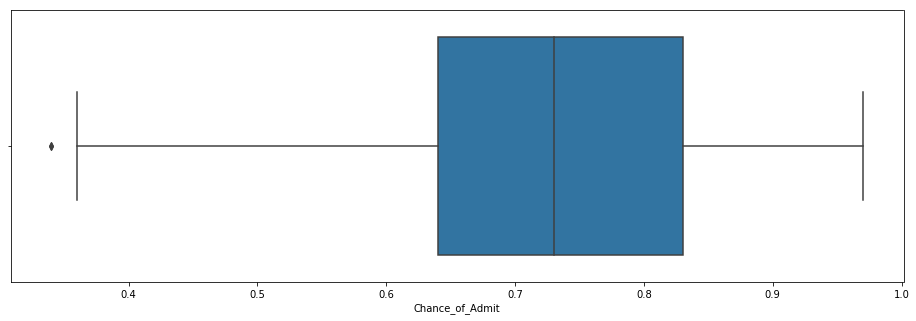

In [3]:
# looking for outliers in the outcome variable
plt.figure(figsize = (16,5))
_ = sns.boxplot(df['Chance_of_Admit'])
plt.show()

,GRE,TOEFL,UR,SOP,LOR,CGPA,Research,Chance_of_Admit
GRE,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
UR,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance_of_Admit,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


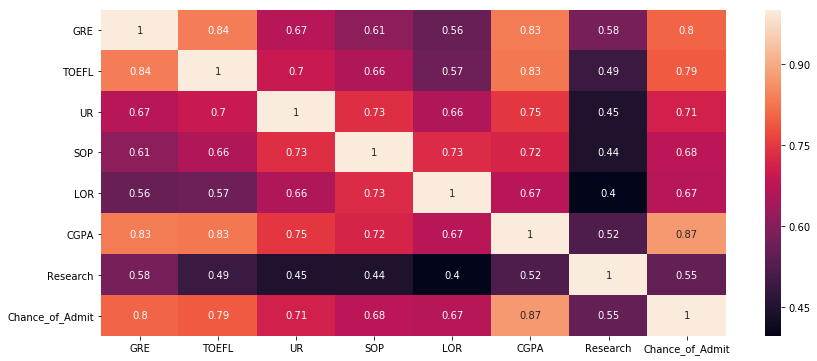

In [4]:
# correlation heatmap
plt.figure(figsize = (14,6))
corr = df.corr()
_ = sns.heatmap(corr, annot = True)

display(corr)

There is highly positively correlation between Chance of Admit and CPGA score (0.87), followed by GRE score and TOEFL score. Seems CPGA, GRE and TOEFL exam scores increase the chance of getting admitted. It's good to check the regression between these variables.

C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


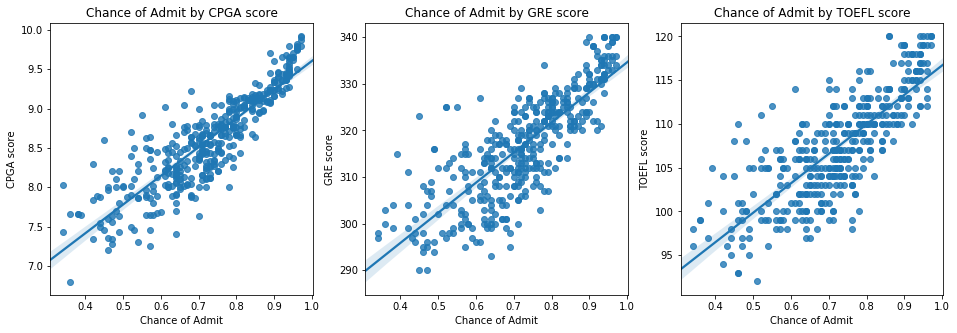

In [5]:
plt.figure(figsize = (16,5))

# chance of admit by CGPA score
plt.subplot(131)
_ = sns.regplot(x = 'Chance_of_Admit', y = 'CGPA', data = df)
_.set(title = 'Chance of Admit by CPGA score', xlabel = 'Chance of Admit', ylabel = 'CPGA score')

# chance of admit by GRE score
plt.subplot(132)
_ = sns.regplot(x = 'Chance_of_Admit', y = 'GRE', data = df)
_.set(title = 'Chance of Admit by GRE score', xlabel = 'Chance of Admit', ylabel = 'GRE score')

# chance of admit by TOEFL score
plt.subplot(133)
_ = sns.regplot(x = 'Chance_of_Admit', y = 'TOEFL', data = df)
_.set(title  = 'Chance of Admit by TOEFL score', xlabel = 'Chance of Admit', ylabel = 'TOEFL score')
plt.show()

Everything looks good. We don't have outliers. I would use all the variables as features. However, for OLS Regression model, inputs to the model need to be consistent with four assumptions. 
From the correlation heatmap, I can see the high multicollinearity issue between CGPA, GRE and TOEFL scores. This sholdn't be a problem if our goal is prediction. 

Before moving forvard, I'll display the distribution of continuous variables.

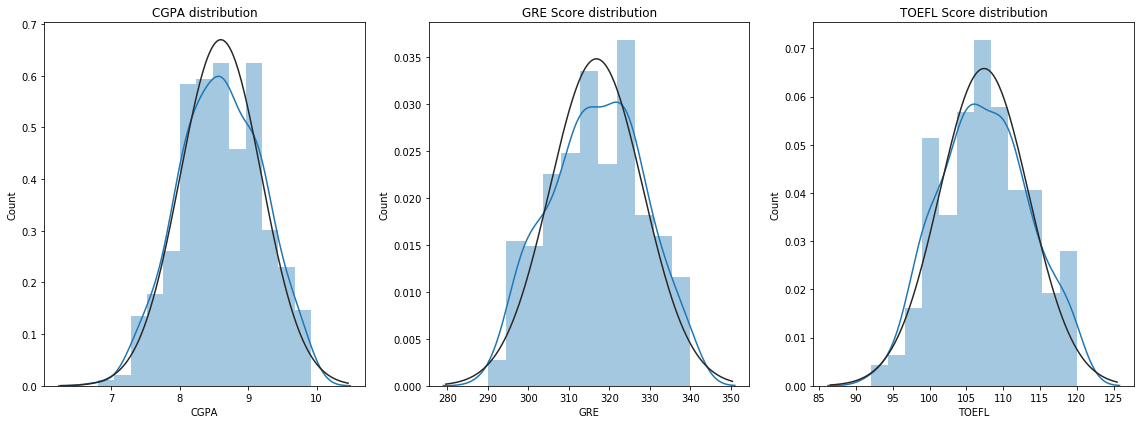

In [6]:
# plot the Population distribution    
plt.figure(figsize = (16,6))
plt.subplot(131)
_ = sns.distplot(df['CGPA'], fit = norm)
_.set(ylabel = 'Count', title = 'CGPA distribution')

plt.subplot(132)
_ = sns.distplot(df['GRE'], fit = norm)
_.set(ylabel = 'Count', title = 'GRE Score distribution')

plt.subplot(133)
_ = sns.distplot(df['TOEFL'], fit = norm)
_.set(ylabel = 'Count', title = 'TOEFL Score distribution')

plt.tight_layout()
plt.show()

All three continous variables are pretty much normally distributed and I can use them as features.

## Model 1. OLS Regression

In [17]:
# fit the model
regr = linear_model.LinearRegression()

X = df.drop(['Chance_of_Admit'], axis = 1)
Y = df['Chance_of_Admit']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: {}'.format(regr.intercept_))
print('\nR-squared: {}'.format(regr.score(X, Y)))


Coefficients: 
 [ 0.00173741  0.00291958  0.00571666 -0.00330517  0.02235313  0.11893945
  0.02452511]

Intercept: -1.2594324782480177

R-squared: 0.8034713719824393


0.8034713719824393

In [8]:
# cross validation with 5 folds
cvs = cross_val_score(regr, X, Y, cv = 5)
print('Cross Validation 5 folds: {}'.format(cvs))
print('mean: {}, std: {}'.format(np.mean(cvs), np.std(cvs)))

Cross Validation 5 folds: [0.66228895 0.76112209 0.78108683 0.84044015 0.81095904]
mean: 0.7711794121066358, std: 0.06072216779200965


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


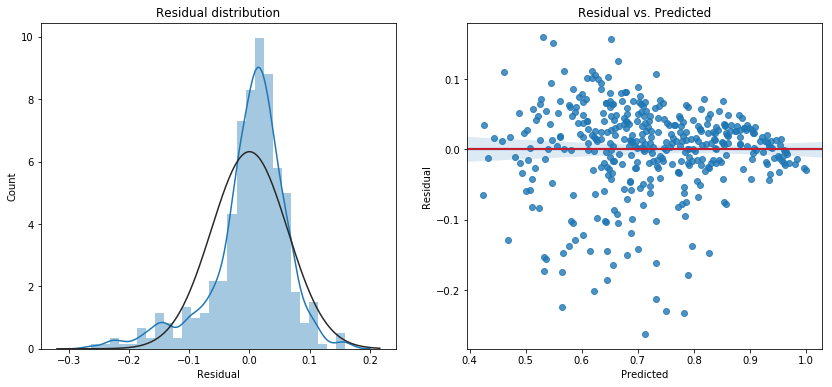

In [9]:
predicted = regr.predict(X).ravel()

# Calculate the error, also called the residual.
actual = df['Chance_of_Admit']
residual = actual - predicted

# plot residual distribution
plt.figure(figsize = (14, 6))
plt.subplot(121)
_ = sns.distplot(residual, fit = norm)
_.set(title = 'Residual distribution', xlabel = 'Residual', ylabel = 'Count')

# scatter plot residual vs. predicted
plt.subplot(122)
_ = sns.regplot(predicted, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Predicted', xlabel = 'Predicted', ylabel = 'Residual')

plt.show()


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


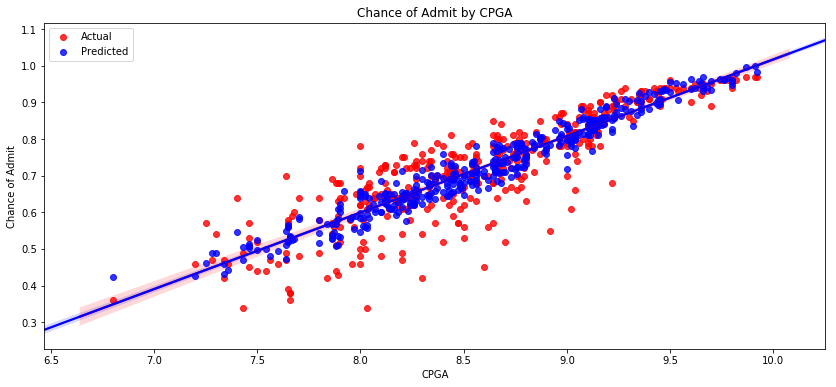

In [11]:
# plot predicted vs actual
Y_lr = regr.predict(X)

# plot predicted property crime vs. actual property crime
plt.figure(figsize = (14,6))
_ = sns.regplot(df.CGPA, Y, color = 'r', label = 'Actual')
_ = sns.regplot(df.CGPA, Y_lr, color = 'b', label = 'Predicted')
_.set(xlabel = 'CPGA', ylabel = 'Chance of Admit', title  = 'Chance of Admit by CPGA' )
plt.legend()
plt.show()


R-squared looks pretty good. The model explains 80% variablity of the response data around its mean. The cross-validation with 5 folds shows the 0.77 mean accuracy. Probably, I don't need to use all the features. To understand the importance of each feature, we need to calculate the p-value for particular feature.

In [12]:
# write out the model formula
formula = 'Chance_of_Admit ~ CGPA+GRE+TOEFL+UR+SOP+LOR+Research'

lm = smf.ols(formula = formula, data = df).fit()

print('Parameters \n', lm.params, '\n')
print('P-values \n', lm.pvalues, '\n')
print('R-square: {}'.format(round(lm.rsquared, 4)))

Parameters 
 Intercept   -1.259432
CGPA         0.118939
GRE          0.001737
TOEFL        0.002920
UR           0.005717
SOP         -0.003305
LOR          0.022353
Research     0.024525
dtype: float64 

P-values 
 Intercept    1.841187e-21
CGPA         3.382038e-20
GRE          3.870080e-03
TOEFL        7.680242e-03
UR           2.315032e-01
SOP          5.526682e-01
LOR          6.599010e-05
Research     2.207647e-03
dtype: float64 

R-square: 0.8035


P-values for University Rating and SOP are above 0.05, suggesting that mentioned features are not significant for the model. 
Next, I'll remove these features from the formula.

In [13]:
# write out the model formula
formula = 'Chance_of_Admit ~ CGPA+GRE+TOEFL+LOR+Research'
lm = smf.ols(formula = formula, data = df).fit()

print('R-square: {}'.format(round(lm.rsquared, 4)))

cvs = cross_val_score(regr, X, Y, cv = 10)
print('Cross Validation 5 folds: {}'.format(cvs))
print('mean: {}, std: {}'.format(round(np.mean(cvs), 2), round(np.std(cvs), 2)))

R-square: 0.8027
Cross Validation 5 folds: [0.79561039 0.56248189 0.69614635 0.83952939 0.68660669 0.90094592
 0.78721837 0.90193049 0.66957933 0.86377621]
mean: 0.77, std: 0.11


## Model 2. KNN Regression

In [24]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 10, weights = 'distance')
X = df[['GRE', 'CGPA','TOEFL','LOR', 'Research']]
Y = df['Chance_of_Admit']

knn.fit(X,Y)
Y_knn = knn.predict(X)

score = cross_val_score(knn, X, Y, cv = 5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('R-squared: ', r2_score(Y, Y_knn))

Weighted Accuracy: 0.66 (+/- 0.20)
R-squared:  1.0


## Comparison of Regression Models

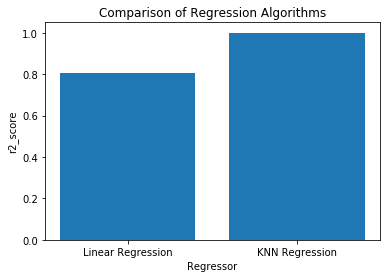

In [30]:
y = np.array([r2_score(Y, Y_lr), r2_score(Y, Y_knn)])
x = ['Linear Regression', 'KNN Regression']
plt.bar(x,y)
plt.title("Comparison of Regression Algorithms")
plt.xlabel("Regressor")
plt.ylabel("r2_score")
plt.show()